#Сверточные нейронные сети

Сегодня мы рассмотрим тип нейронных сетей, с которыми обычно связывают первые state-of-the-art успехи нейронных сетей - сверточные нейронные сети.



## ImageNet

Конкретно, сверточные нейорнные сети (AlexNet) уменьшили ошибку классификации изображений в конкурсе ImageNet в полтора раза.

После 2012 года в этом конкурсе всегда используются нейронные сети и методы, основанные на них


<img src ="https://kodomo.fbb.msu.ru/FBB/year_20/ml/imagenet.png"  width="700">

## Нарушение связей между соседними пикселями

Чтобы разобраться в причинах успеха, давайте сначала разберемся, в чем состоит проблема работы с изображениями обычными методами классического ML и многослойными персептронами?

Для того, чтобы работать с изображением обычными методами, при этом без дополнительной предобработки, а кормить изображение as is - его надо растянуть в одномерный вектор.

В результате такого преобразования теряется связь между соседними пикселями.


<img src ="https://www.programmersought.com/images/783/bad2258e403444a44a571786ac57a5df.png" width="300px">

Точнее - связь остается, но она становится неявной. Модель нужно самой понять, что 1, 20 и 30 точки в одномерном векторе представляют собой пиксели, которые на самом деле лежат рядом, а 4,5,6 - нет.








Модели нужно самой догадаться, что ухо может быть расположено в любой части изображения и потому к определенным частям вектора должны быть применены одни и те же веса.

<img src ="https://kodomo.fbb.msu.ru/FBB/year_21/cat_aug.png"  width="700">

Обычно модель не в состоянии этого понять, особенно если выборка "мала".

А малость выборки отчасти определяется и числом весов, которые надо учить.
Пусть для нейронных сетей число реально используемых весов и "сложность" модели неочевидно коррелирует с числом весов в сети, все равно, подход, основанный на обычной многослойной нейросети приведет еще и к следующему:





In [ ]:
import torch
import torch.nn as nn


class SimpleImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(3072, 500),
                                   nn.ReLU(),
                                   nn.Linear(500, 100),
                                   nn.ReLU(),
                                   nn.Linear(100, 10))

    def forward(self, x):
        return self.model(x)


def parameter_count(model):
    pars = 0
    for tag, p  in model.named_parameters():
        pars += torch.prod(torch.tensor(p.shape))
    return pars



In [ ]:
parameter_count(SimpleImageClassifier())

tensor(1587610)

Мы сделали всего лишь трехслойную нейронную сеть, а у нас уже полтора миллиона параметров.

А если изображение будет больше? А уверены ли мы, что нам хватит трех слоев?

При этом, еще раз, заметим - бОльшая часть из этих параметров вырождены - нейросеть должна одинаково искать глаз кошки на всей фотографии, потому нейроны, отвечающие за поиск этого глаза будут иметь похожие веса.

В случае классических методов проблема аналогична - большое число входных признаков, которые еще сильно друг с другом коррелированы, при этом каждый в отдельности говорит нам очень мало информации.
Деревья решений в таком случае в принципе работать не будут - им просто не хватит информации, чтобы правильно разделять классы.

## Интуиция

До этого мы пытались заставить нашу нейросеть на основе вектора входов выучить какую-то функцию

<img src="https://colah.github.io/posts/2014-07-Conv-Nets-Modular/img/Conv-9-F.png" width="500px">

Теперь мы хотим сделать хитрее - допустим, наши входы локально связаны. Давайте мы сделаем нейросеть из двух частей.

Первая часть (A) будет локальной - она будет для каждого набора рядом лежащих входов предсказывать какое-то значение, например, кодируют ли эти входы ухо кошки.

<img src="https://colah.github.io/posts/2014-07-Conv-Nets-Modular/img/Conv2-unit.png" width="300px">



Будем для каждой локальной области делать предсказание нашей маленькой сетью

<img src="https://colah.github.io/posts/2014-07-Conv-Nets-Modular/img/Conv2-5x5-Conv2-XY.png" width="400px">


А далее уже на основе предсказаний этой нейросети, наша полносвязная сеть F будет делать финальное предсказание.

<img src="https://colah.github.io/posts/2014-07-Conv-Nets-Modular/img/Conv2-9x5-Conv2.png" width="500px">

При желании мы можем даже на предсказания локальной сети A, "натравить" локальную сеть B, которая будет на основе простых преддказаний A (например, A предсказывает наличие линий на изображении), предсказывать более сложные паттерны (то же ухо кошки)

<img src="https://colah.github.io/posts/2014-07-Conv-Nets-Modular/img/Conv2-9x5-Conv2Conv2.png" width="500px">

Заметьте, что у нас получается иерархическая структура - сеть A выделяет простой локальный признак, наличие линии. Сеть опять же, пользуясь тем, что мы сохранили взаиморасположение предсказаний сети A, предсказывает что-то более сложное. А затем уже на предсказание этого сложного по всему изображению смотрит сеть F, которая аггрегирует иннформацию со всего изображения

## Свертка

И тут к нам на помощь приходит то, как решали некоторые задачи компьютерного зрения до появления нейронных сетей.




### Фильтр Собеля

На заре компьютерного зрения люди придумывали различные операции, которые будут находить важные элементы на изображении. К примеру, границы. Примером подобной операции является фильтр Собеля.

<img src ="https://kodomo.fbb.msu.ru/FBB/year_20/ml/sobel.png" width="300">


### Интуиция

Как это работает?

Для того, чтобы понять это, нам придется ввести понятие свертки.

Представим, что мы ищем некий шаблон в одномерном сигнале. Например - квадратик.
Как бы нам проверить весь сигнал на наличие этого шаблона в каждой позиции?

Нарисуем, как выглядит наш квадрат, и будем его прикладывать в каждой точке сигнала и считать, насколько совпал сигнал и наш квадрат (например, по доли площади)

Чем больше совпадение - тем больше реакция.

<img src ="https://camo.githubusercontent.com/3cede2a63680184a906b414c7d64d3b90c06d842/687474703a2f2f6564756e65742e6b65612e73752f7265706f2f7372632f4c30365f434e4e2f696d672f4c30362e676966" width="900">

Таким образом на основе одномерного сигнала и некоего паттерна мы получаем новый одномерный сигнал, который содержит информацию о силе проявления данного паттерна вдоль одномерного сигнала.




### Одномерная свертка

Как записать это в математическом виде?

На самом деле - очень просто.

Одномерный сигнал - это просто массив из чисел.

Наш паттерн, схожесть с которым мы меряем - тоже массив, называется **ядром** свертки

<img src =" https://kodomo.fbb.msu.ru/FBB/year_21/1d_simple_conv.png" width="900">




#### Производная

На самом деле свертка не обязательно соответствует какому-то паттерну. Она может и считать какую-то локальную операцию.

Например, посчитать приближенное значение производной в каждой точке сигнала.

$$f'(x) = \dfrac {f(x + \Delta) - f(x - \Delta) } {2\Delta} $$



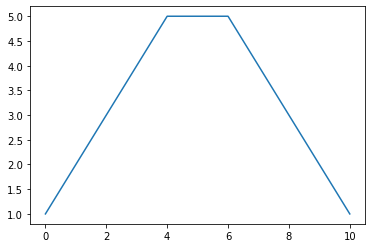

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
signal = np.array([1,2,3,4,5,5,5,4,3,2,1])
plt.plot(signal)

In [ ]:
deriv = np.array([-1, 0, 1]) / 2

res = np.zeros(signal.shape[0] - 2)
for i in range(0, signal.shape[0] - 2):
    res[i] = np.sum(deriv * signal[i:i+3])

print(res)

[ 1.   1.   1.   0.5  0.  -0.5 -1.  -1.  -1. ]


Аналогично можно написать ядро, считающее вторую производную

$$f''(x) \approx \dfrac {f(x + \Delta) - 2 f(x) +  f(x - \Delta) } {\Delta ^ 2 } $$


In [ ]:
import numpy as np
x = np.linspace(-5, 5, num=100)
signal = x ** 4
afsecond = 12 * x ** 2

deriv2 = np.array([1,-2, 1])  / (x[1] - x[0]) ** 2



res = np.zeros(signal.shape[0] - 2)
for i in range(0, signal.shape[0] - 2):
    res[i] = np.sum(deriv2 * signal[i:i+3])



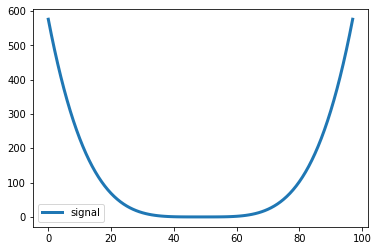

In [ ]:
plt.plot(signal[1:-1], label="signal", linewidth=3)
plt.legend()

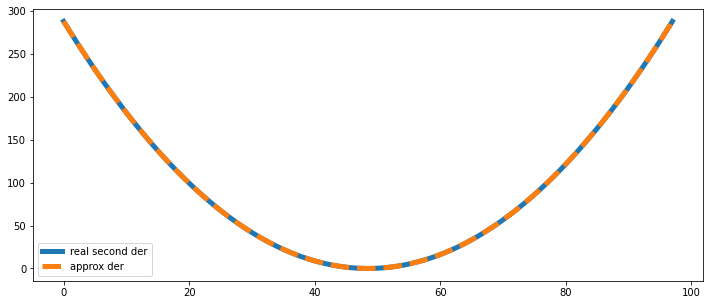

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(afsecond[1:-1], label="real second der", linewidth=5)
plt.plot(res, "--", label="approx der", linewidth=5)
plt.legend()

Видим, что вид аналитического решения и того, что мы посчитали приблизительно, практически совпадает

### 2D случай

В случае черно-белых двумерных изображений информация у нас хранится в двух измерениях.

Потому и свертки должны быть двумерные.

Остальное не меняется.

![alttext](https://miro.medium.com/max/1400/1*D6iRfzDkz-sEzyjYoVZ73w.gif)


Вопрос на засыпку - что считает конволюция на картинке?



### Примеры

In [ ]:
from skimage import data
import matplotlib.pyplot as plt
import numpy as np

camera = data.camera()


def conv(x, filter):

  K = filter.shape[0]
  M, N = x.shape
  M_, N_ = 1 + M - K, 1 + N  - K
  matrix = np.zeros((M_, N_))
  for i in range(0, M - K + 1, 1):
    for j in range(0, N - K + 1, 1):
      matrix[i , j ] = np.sum(x[i:i + K, j : j + K] * filter)
  return matrix



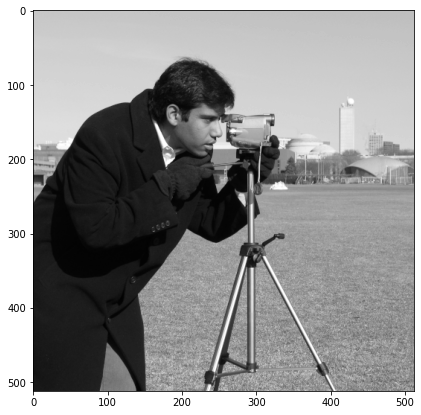

In [ ]:
plt.figure(figsize=(7,7))

plt.imshow(camera, cmap='gray', vmin=0, vmax=255)

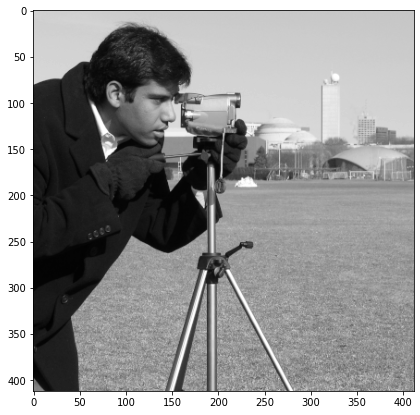

In [ ]:
plt.figure(figsize=(7,7))
shift_filt = np.zeros((101,101))
shift_filt[50, -1] = 1
camera_shift= conv(camera, shift_filt)
plt.imshow(camera_shift, cmap='gray', vmin=0, vmax=255)

Можно сделать размывающий фильтр - заменяем каждый пиксель средним в окне вокруг него

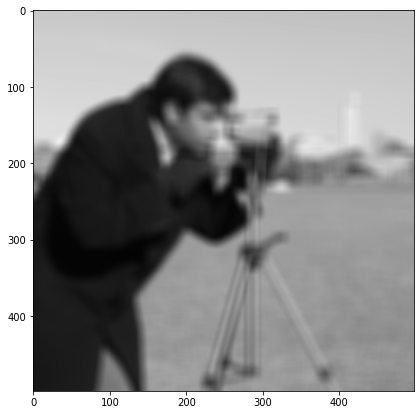

In [ ]:
plt.figure(figsize=(7,7))
blur_filt = np.ones((15,15)) / (15 * 15)
camera_blur= conv(camera, blur_filt)
plt.imshow(camera_blur, cmap='gray', vmin=0, vmax=255)

Или сделать изображение более резким

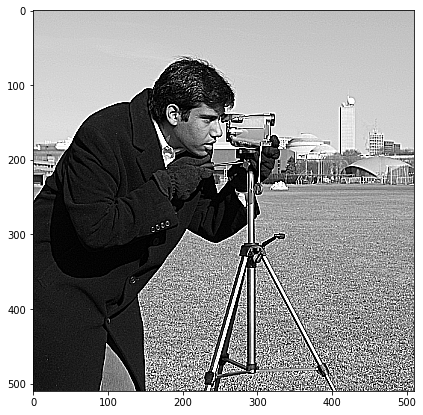

In [ ]:
plt.figure(figsize=(7,7))
sharp_filt = np.array([[-1, -1, -1,],
  [-1,  9, -1],
  [-1, -1, -1]])
camera_sharp= conv(camera, sharp_filt)
plt.imshow(camera_sharp, cmap='gray', vmin=0, vmax=255)



## Каналы

До этого мы предполагали, что наш сигнал имеет только одно измерение - время.
А картинка - черно-белая.

Но что делать, если измерение не одно. Самый простой пример - трехцветное изображение

Логично, что мы хотим иметь возможность делать искомый паттерн тоже трехцветным - то есть теперь у нас фильтр конволюции тоже имеет каналы.

И что и как с этим делать?

Сначала берем и на каждый канал исходного изображения применяем соответствующий канал фильтра

![alttext](https://miro.medium.com/max/2000/1*8dx6nxpUh2JqvYWPadTwMQ.gif)

И затем складываем полученные отклики
![alttext](https://miro.medium.com/max/2000/1*CYB2dyR3EhFs1xNLK8ewiA.gif)


Сейчас нам это не принципиально, но в случае нейросетей мы можем добавлять к резуультату еще некую константу (bias) - чтобы иметь возможность смещать тот же сигнал в ту или иную область функции активации



![alttext](https://miro.medium.com/max/588/1*RYYucIh3U-YFxrIkyQKzRw.gif)

Заметим, что при этом из трехканального изображения мы получили **одноканальный сигнал**

### RGB to grayscale


$$Grayscale  = 0.299R + 0.587G + 0.114B$$




Можем даже эту операцию при желании записать в виде свертки

In [ ]:
from skimage import data
import matplotlib.pyplot as plt
import numpy as np

def conv(x, filter):
  K = filter.shape[0]
  M, N, _ = x.shape
  M_, N_ = 1 + M - K, 1 + N  - K
  matrix = np.zeros((M_, N_))


  for i in range(0, M - K + 1, 1):
    for j in range(0, N - K + 1, 1):
      matrix[i , j] = np.sum(x[i:i + K, j : j + K] * filter)

  return matrix



In [ ]:
coffee = data.coffee()

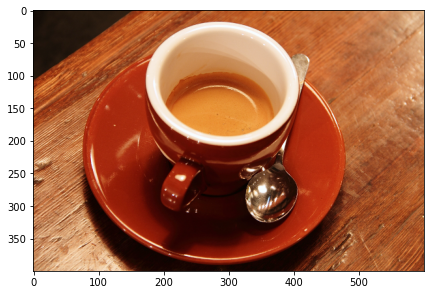

In [ ]:
plt.figure(figsize=(7,7))
plt.imshow(coffee, vmin=0, vmax=255)





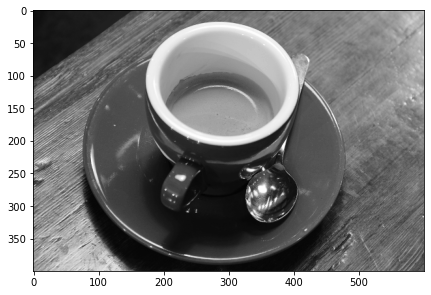

In [ ]:
plt.figure(figsize=(7,7))
greyscale_filt = np.ones((1, 1, 3))
greyscale_filt[:, :, 0] = 0.299
greyscale_filt[:, :, 1] = 0.587
greyscale_filt[:, :, 2] = 0.114

coffee_sharp= conv(coffee, greyscale_filt)
plt.imshow(coffee_sharp, cmap='gray', vmin=0, vmax=255)



Подобные фильтры до сих испоьзуются в программах фотошопа и им подобных

### Границы

Можно посмотреть все границы

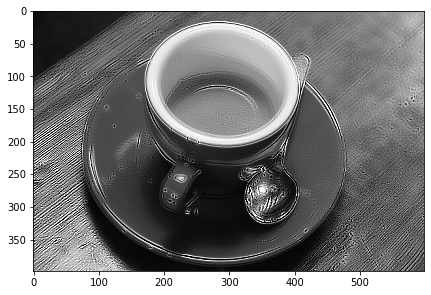

In [ ]:
plt.figure(figsize=(7,7))

onec = np.array([[1,  1,  1,],
   [1, -7,  1],
   [1,  1,  1]]).reshape(3, 3, 1)
edge_filt = np.concatenate([onec, onec, onec], axis=2) / 3

coffee_edge= conv(coffee, edge_filt)
plt.imshow(coffee_edge, cmap='gray', vmin=0, vmax=255)

### Поиск паттерна

Можем спрятать на изображении какой-то паттерн. Например - желтый квадрат 50 на 50 пикселей

In [ ]:
coffee.shape

(400, 600, 3)

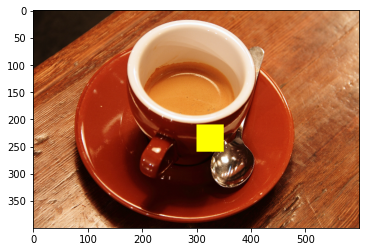

In [ ]:
coffee = data.coffee()
w = 50
coffee[210:210+w, 300:300+w, 0] = 255
coffee[210:210+w, 300:300+w, 1] = 255
coffee[210:210+w, 300:300+w, 2] = 0
plt.imshow(coffee,  vmin=0, vmax=255)

И добавим несколько ложных следов



In [ ]:
coffee[310:310+w, 200:200+w, 0] = 255
coffee[310:310+w, 200:200+w, 1] = 0
coffee[310:310+w, 200:200+w, 2] = 255

In [ ]:
coffee[110:110+w, 100:100+w, 0] = 128
coffee[110:110+w, 100:100+w, 1] = 128
coffee[110:110+w, 100:100+w, 2] = 128

In [ ]:
coffee[110:110+w, 300:300+w, 0] = 0
coffee[110:110+w, 300:300+w, 1] = 128
coffee[110:110+w, 300:300+w, 2] = 128

In [ ]:
np.random.seed(777)
i = np.random.choice(400, 1000)
j = np.random.choice(600, 1000)
coffee[i, j, 0] = 255
coffee[i, j, 1] = 255
coffee[i, j, 2] = 0

In [ ]:
i = np.random.choice(400 - 5, 1000)
j = np.random.choice(600 - 5, 1000)

for si in range(0, 5):
  for sj in range(0,5):
    coffee[i + si, j + sj, 0] = 255
    coffee[i + si, j + sj, 1] = 255
    coffee[i + si, j + sj, 2] = 0

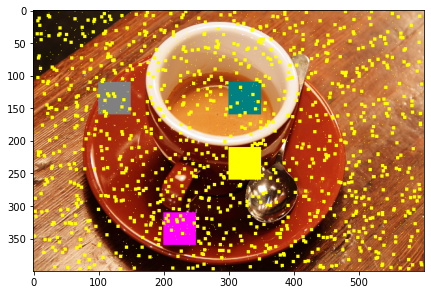

In [ ]:
plt.figure(figsize=(7,7))
plt.imshow(coffee,  vmin=0, vmax=255)

Напишем фильтр, который будет искать наш квадратик

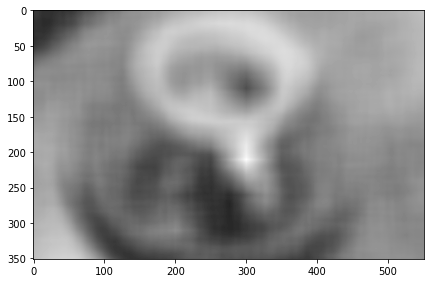

In [ ]:
yellow_square = np.stack([np.ones( (w,w)), np.ones( (w,w)), np.zeros((w,w))], axis=2) / (w * w * 2)

coffee_square= conv(coffee, yellow_square )

plt.figure(figsize=(7,7))
plt.imshow(coffee_square, cmap='gray', vmin=0, vmax=255)

In [ ]:
yellow_square

array([[[0.0002, 0.0002, 0.    ],
        [0.0002, 0.0002, 0.    ],
        [0.0002, 0.0002, 0.    ],
        ...,
        [0.0002, 0.0002, 0.    ],
        [0.0002, 0.0002, 0.    ],
        [0.0002, 0.0002, 0.    ]],

       [[0.0002, 0.0002, 0.    ],
        [0.0002, 0.0002, 0.    ],
        [0.0002, 0.0002, 0.    ],
        ...,
        [0.0002, 0.0002, 0.    ],
        [0.0002, 0.0002, 0.    ],
        [0.0002, 0.0002, 0.    ]],

       [[0.0002, 0.0002, 0.    ],
        [0.0002, 0.0002, 0.    ],
        [0.0002, 0.0002, 0.    ],
        ...,
        [0.0002, 0.0002, 0.    ],
        [0.0002, 0.0002, 0.    ],
        [0.0002, 0.0002, 0.    ]],

       ...,

       [[0.0002, 0.0002, 0.    ],
        [0.0002, 0.0002, 0.    ],
        [0.0002, 0.0002, 0.    ],
        ...,
        [0.0002, 0.0002, 0.    ],
        [0.0002, 0.0002, 0.    ],
        [0.0002, 0.0002, 0.    ]],

       [[0.0002, 0.0002, 0.    ],
        [0.0002, 0.0002, 0.    ],
        [0.0002, 0.0002, 0.    ],
        .

Видим зону больших значений - белые пиксели - в основном сосредоточенные в районе нашего квадратика

In [ ]:
np.unravel_index(coffee_square.argmax(), coffee_square.shape)

(210, 300)

Действительно, максимум лежит именно там, где мы загадали

Если добавить несколько квадратов - то будет несколько областей с максимумом

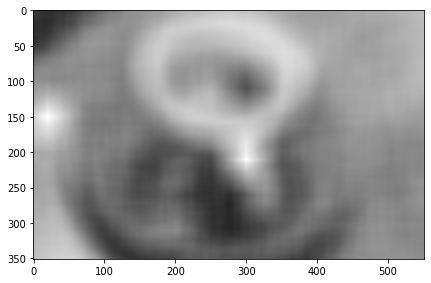

In [ ]:
coffee[150:150+w, 20:20+w, 0] = 255
coffee[150:150+w, 20:20+w, 1] = 255
coffee[150:150+w, 20:20+w, 2] = 0

coffee_square= conv(coffee, yellow_square )

plt.figure(figsize=(7,7))
plt.imshow(coffee_square, cmap='gray', vmin=0, vmax=255)

Далее мы можем сказать, что мы допускаем отклонение от идеального квадратика на, например, 5, все остальное - шум

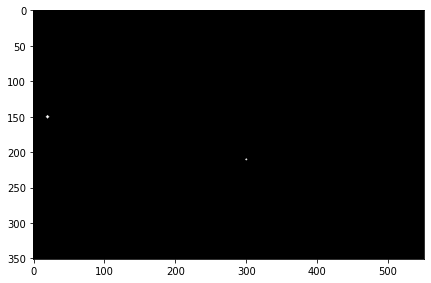

In [ ]:
coffee_square[coffee_square < 255 - 5] = 0
plt.figure(figsize=(7,7))
plt.imshow(coffee_square, cmap='gray', vmin=0, vmax=255)

Фактически - мы применили функцию активации - ReLU (с порогом не в нуле)

<img src="https://www.researchgate.net/profile/Hossam-H-Sultan/publication/333411007/figure/fig7/AS:766785846525952@1559827400204/ReLU-activation-function.png" width="500px">

Более того, при желании можнно и применить обычный ReLU - просто из сигнала вычитаем перед его применением вычитаем 250. Все, что меньше 250 перестанем подавать сигнал. То есть кроме фильтра нам понадобится дополнительный вес - **bias**

И получили "картинку" - feature map, которая содержит информацию о том, где на исходной картинке лежат квадратики

### Поиск составного паттерна

А что если нам нужен не простой паттерн, а, включающий несколько подпаттернов?

Наш фильтр выше, кстати, не идеален - он будет реагировать как на желтый квадрат, так и на белый. Можно поправить это руками (добавив вычитание на слой ядра, работающий с синим цветом). А можно сделать немного иначе.



Мы хотим находить только красные квадраты.

Мы не хотим находить желтые квадраты и розовые (которые тоже содержат красный цвет).
Для простоты задачи мы не штрафуем (и не награждаем себя) за реакцию на белые квадраты.

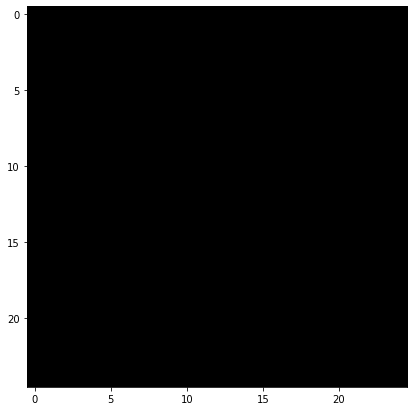

In [ ]:
blank = np.zeros((25, 25, 3), dtype=np.uint8)
plt.figure(figsize=(7,7))
plt.imshow(blank)

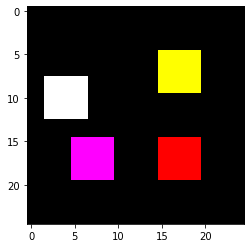

In [ ]:
blank = np.zeros((25, 25, 3), dtype=np.uint8)

x = 15
y = 15
w = 5

blank[x:x+w, y:y+w, 0] = 255
blank[x:x+w, y:y+w, 1] = 0
blank[x:x+w, y:y+w, 2] = 0

blank[x-10:x+w-10, y:y+w, 0] = 255
blank[x-10:x+w-10, y:y+w, 1] = 255
blank[x-10:x+w-10, y:y+w, 2] = 0


blank[x:x+w, y-10:y-10+w, 0] = 255
blank[x:x+w, y-10:y-10+w, 1] = 0
blank[x:x+w, y-10:y-10+w, 2] = 255


blank[x-7:x-7+w, y-13:y-13+w, 0] = 255
blank[x-7:x-7+w, y-13:y-13+w, 1] = 255
blank[x-7:x-7+w, y-13:y-13+w, 2] = 255

plt.imshow(blank,  vmin=0, vmax=255)

Решим эту задачу, сведя к предыдущей.

Сначала напишем свертки, которые детектят красные, желтые и розовые квадраты


Сделаем по свертке на каждый тип квадрата

In [ ]:
red_square = np.stack([np.ones( (w,w)), np.zeros( (w,w)), np.zeros((w,w))], axis=2) / (w * w )
yellow_square = np.stack([np.ones( (w,w)), np.ones( (w,w)), np.zeros((w,w))], axis=2) / (w * w * 2)
pink_square = np.stack([np.ones( (w,w)), np.zeros( (w,w)), np.ones((w,w))], axis=2) / (w * w * 2)

blank_y_square= conv(blank, yellow_square)
blank_r_square= conv(blank, red_square)
blank_p_square= conv(blank, pink_square)

Обрежем шум, скажем, все места, где сигнал меньше 250

In [ ]:
blank_y_square[blank_y_square < 250] = 0
blank_r_square[blank_r_square < 250] = 0
blank_p_square[blank_p_square < 250] = 0

А теперь объединим их в единую матрицу, трактуя их как каналы нового изображения))

Активации желтого фильтра будут трактоваться как красный цвет, красного фильтра - как зеленый, а белого - как синий




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


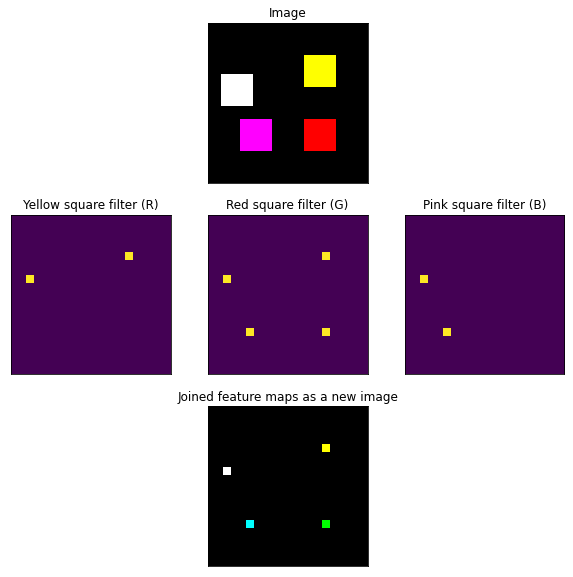

In [ ]:
simple_features = np.stack([blank_y_square, blank_r_square, blank_p_square], axis=2)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10))

ax[0, 1].set_title("Image")
ax[0, 1].imshow(blank,  vmin=0, vmax=255)
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])
ax[0, 0].axis('off')
ax[0, 2].axis('off')


ax[1, 0].set_title("Yellow square filter (R)")
ax[1, 0].imshow(blank_y_square)
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])
ax[1, 1].set_title("Red square filter (G)")
ax[1, 1].imshow(blank_r_square)
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])
ax[1, 2].set_title("Pink square filter (B)")
ax[1, 2].imshow(blank_p_square)
ax[1, 2].set_xticks([])
ax[1, 2].set_yticks([])

ax[2, 1].set_title("Joined feature maps as a new image")
ax[2, 1].imshow(np.asarray(simple_features, dtype=np.int))
ax[2, 1].set_xticks([])
ax[2, 1].set_yticks([])
ax[2, 0].axis('off')
ax[2, 2].axis('off')
plt.subplots_adjust()
plt.show()

Видно, что красный квадрат распознался только красным фильтром (зеленый квадратик), белый - всеми (белый квадратик), желтый - красным и желтым (желтый квадратик), а фиолетовый - фиолетовым и желтым (голубой квадратик = зеленый + синий цвета)

А теперь трактуем эту матрицу как новое изображение. И напишем для нее фильтр. Фильтр будет выглядеть просто - мы хотим занулять те позиции, где встретился и красный квадрат, и желтый или фиолетовый.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


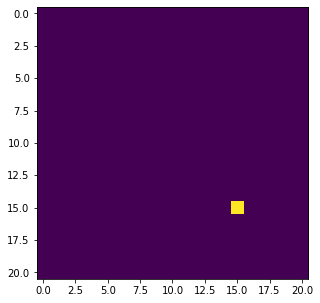

In [ ]:
feature_filter = np.zeros((1, 1, 3))
feature_filter[:, :, 0] = -2 # penalty for yellow
feature_filter[:, :, 1] = 1
feature_filter[:, :, 2] = -2 # penalty for pink


final_img = conv(simple_features, feature_filter)

final_img[final_img < 250] = 0

plt.figure(figsize=(5,5))
plt.imshow(np.asarray(final_img , dtype=np.int),  vmin=0, vmax=255)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

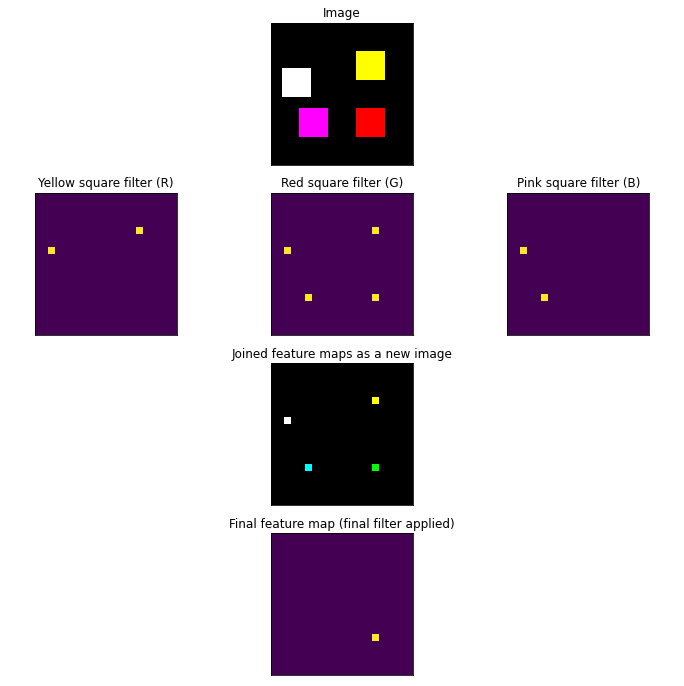

In [ ]:
simple_features = np.stack([blank_y_square, blank_r_square, blank_p_square], axis=2)

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))

ax[0, 1].set_title("Image")
ax[0, 1].imshow(blank,  vmin=0, vmax=255)
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])
ax[0, 0].axis('off')
ax[0, 2].axis('off')


ax[1, 0].set_title("Yellow square filter (R)")
ax[1, 0].imshow(blank_y_square)
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])
ax[1, 1].set_title("Red square filter (G)")
ax[1, 1].imshow(blank_r_square)
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])
ax[1, 2].set_title("Pink square filter (B)")
ax[1, 2].imshow(blank_p_square)
ax[1, 2].set_xticks([])
ax[1, 2].set_yticks([])

ax[2, 1].set_title("Joined feature maps as a new image")
ax[2, 1].imshow(np.asarray(simple_features, dtype=np.int))
ax[2, 1].set_xticks([])
ax[2, 1].set_yticks([])
ax[2, 0].axis('off')
ax[2, 2].axis('off')

ax[3, 1].set_title("Final feature map (final filter applied)")
ax[3, 1].imshow(np.asarray(final_img , dtype=np.int),  vmin=0, vmax=255)
ax[3, 1].set_xticks([])
ax[3, 1].set_yticks([])
ax[3, 0].axis('off')
ax[3, 2].axis('off')

plt.subplots_adjust()
plt.show()

Видим, что теперь мощный сигнал дает только красный квадрат

In [ ]:
np.unravel_index(final_img.argmax(), final_img.shape)

(15, 15)

В данном случае, однако, можно было обойтись и без конволюции - просто вычесть одни feature map из других.

Но что, если нам, например, паттерн, состоящий из красного  квадрата и желтого, отстоящих друг от друга на расстоянии 50 по вертикали?

Тут тоже можно придумать фильтр, который будет на основе более простых признаков, делать более сложные - вплоть до решения задачи.

В этом и заключается смысл конволюционных сетей, которые мы рассмотрим далее - сначала выделить на изображении простые признаки, потом объединить их в более сложные и т.д

## Сверточный слой

### Обучаемые фильтры

Первое отличие от того, что мы разобрали - веса фильтров мы будем учить, а не подбирать руками.

Фактически - мы будем учить кучу маленьких нейросеток, которые будут выделять нам необходимые признаки, как обсуждали ранее

<img src="https://colah.github.io/posts/2014-07-Conv-Nets-Modular/img/Conv2-unit.png" width="300px">


### Фильтров много

Но - каждый слой нейросетки будет представлять из себя НАБОР таких нейросеток - фильтров. Каждый будем искать свой паттерн, потому на выходе мы будем получать не один слой, содержащий информацию о вхождения одного паттерна, а много слоев, каждый из которых содержит информацию о своем параметре

<img src ="https://indoml.files.wordpress.com/2018/03/convolution-with-multiple-filters2.png" width="700">

### Bias

По-умолчанию к результату свертки добавляется число - bias.

<img src="https://indoml.files.wordpress.com/2018/03/one-convolution-layer1.png" width="600px">

### nn.Conv

Как будет выглядеть сверточный слой в pytorch - просто объект класса nn.Conv2d(или nn.Conv1d, nn.Conv3d в зависимости от вашей задачи )

In [ ]:
import torch.nn as nn
help(nn.Conv2d)

Help on class Conv2d in module torch.nn.modules.conv:

class Conv2d(_ConvNd)
 |  Conv2d(in_channels: int, out_channels: int, kernel_size: Union[int, Tuple[int, int]], stride: Union[int, Tuple[int, int]] = 1, padding: Union[str, int, Tuple[int, int]] = 0, dilation: Union[int, Tuple[int, int]] = 1, groups: int = 1, bias: bool = True, padding_mode: str = 'zeros', device=None, dtype=None) -> None
 |  
 |  Applies a 2D convolution over an input signal composed of several input
 |  planes.
 |  
 |  In the simplest case, the output value of the layer with input size
 |  :math:`(N, C_{\text{in}}, H, W)` and output :math:`(N, C_{\text{out}}, H_{\text{out}}, W_{\text{out}})`
 |  can be precisely described as:
 |  
 |  .. math::
 |      \text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
 |      \sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)
 |  
 |  
 |  where :math:`\star` is the valid 2D `cross-correlation`_ operator,
 |  :math:`N

Теперь надо понять, что значат все эти страшные аргументе в конструкторе слоя.

Разберем не все, а основные параметры.

1. **in_channels** - сколько каналов (feature_map) во входном изображении.
2. **out_channels** - сколько feature map должен слой подсчитывать. Фактически - сколько признаков слой выделяет во входном изображении
3. **kernel_size** - размер ядра свертки.

Это обязательные аргументы. В принципе, задав их, можно получить сверточный слой.


In [ ]:
nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)

Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))

Но есть еще пара аргументов, которые нам надо разобрать.

### Stride

До этого у нас ядро конволюции шло по всему изображению, каждый раз сдвигаясь на 1 шаг.

<img src ="https://miro.medium.com/max/1120/1*L4T6IXRalWoseBncjRr4wQ@2x.gif" width="700">





Можно этот шаг сделать больше.

<img src ="https://miro.medium.com/max/1120/1*4wZt9G7W7CchZO-5rVxl5g@2x.gif" width="700">


Зачем? Это позволяет нам эффективнее  уменьшать изначальный размер изображения при прохождении через свертки.

Почему так можно делать - часто соседний ячейки feature map с stride=1 будут содержать сильно похожую информацию - можем часть такой feature map "выкинуть"

In [ ]:
nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2)

Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))

### Padding

Все это время мы умолчивали о том, что свертки по-умолчанию меняют размер изображения. Обычно мы не хотим такого поведения, иногда нам не хочется, чтобы размер изображения менялся после применения свертки

Есть несколько возможных вариантов поведения в данной ситуации и они решаются параметром **padding**.







Суть любого padding заключается в том, что мы расширяем изображение за счет значений, добавляемых по краям.

Можно добавлять разные значения, это зависит от задачи, но обычно достаточно просто добавить 0.

#### padding = "same"




Например, можем добавить 0 столько, чтобы размер изображения не менялся. Для случая, когда stride =1, а K=3, достаточно добавить по одному ряду 0 с каждой стороны изображения.

<img src ="https://miro.medium.com/max/1120/1*W2D564Gkad9lj3_6t9I2PA@2x.gif" width="700">

In [ ]:
nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding="same")

Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)

Аналогично можно задавать любой padding, чтобы добиться размерности изображения, которая вам нужна. Но чаще всего либо padding не делают, либо делают same

Понятно, что можно комбинировать stride и padding. Например, здесь padding = 1, stride = 2

<img src ="https://miro.medium.com/max/632/0*7jADX-ITpobLZZPj.gif" width="500">


### Dilation (Atrous convolutions)



Также в биологии может быть интересен параметр **dilation**,который позволяет использовать ядро с пропусками между ячейками.

<img src ="https://miro.medium.com/max/632/1*SVkgHoFoiMZkjy54zM_SUw.gif" width="500">


Это позволяет игнорировать рядом стоящие сигналы (так как они скорее всего коррелированы и потому из них много информации не извлечешь) и не увеличивая число параметров нейросети осматривать одним шагом конволюции большую область (receptive field, разберем дальше)

### bias=False

В некоторых случаях bias можно занулять, так же как и в линейном слое. Например, если используется конволюции вместе с BatchNorm, который мы разберем в следующей лекции

### Пример простой сверточной сети

<img src="https://indoml.files.wordpress.com/2018/03/cnn-complete2.png" width="600px">

## Рецептивное поле или как понять, что конволюций достаточно

Есть еще один вопрос - как понять, что в нашей архитектуре достаточно конволюций?

Вопрос не имеет точного ответа - но главным образом это  зависит от размера паттерна, который мы будем искать

Каждое применения ядра концолюционного слоя видит лишь малую часть переданного ему входа.

<img src ="https://miro.medium.com/max/1120/1*YpXrr8bN5XyqOlztKPHvDw@2x.png" width="900">

Например, два последовательных конвоюционных слоя с ядром 3x3 породят feature map, каждое значение в которых будет аккамулировать информацию только с поля 5x5 пикселей изначального изображения.

То есть скорее всего полученный слой не будет содержать признаков типа "кошка".

Чем глубже нейросеть - чем больше в ней сверток, тем больше будет размер feature map (можно увеличивать и размер ядра свертки, но это приведет к большому росту параметров сетки)





### Как выглядит иерархия признаков в реальности

<img src="https://www.researchgate.net/profile/Shoaib-Siddiqui-4/publication/317558591/figure/fig4/AS:511878728253445@1499052807279/Hierarchical-representation-learning-by-a-Convolutional-Neural-Network-where-the-initial.png" width="500px">

## Pooling



Хотелось бы наконец-то начать использовать сверточные нейронные сети, но к сожалению, для этого надо ознакомиться с еще одним слоем.


Дело в том, что нам бы хотелось на выходе нейронной сети получать какое-то одно число в случае бинарной классификации. Или больше - но по-любому это сильно меньше размеров обычного изображения.

В результате, на каком-то этапе наших сверток нам придется как-то превращать их выход в одномерный вектор. И, возможно, добавлять после этого еще линейные слои.
Если одномерный вектор получится очень большим - мы получим те же проблемы, что имели и без сверток.

Потому нам надо уметь как-то эффективно уменьшать размерность изображения (WxH)

Кроме того, нам бы хотелось иметь возможность размер рецептивного поля не увеличивая число параметров

Одним из решений описанных проблем является Pooling


Просто берем и в каждом окне определенного размера выбираем максимальное (MaxPooling)
<img src ="https://miro.medium.com/max/1120/1*ReZNSf_Yr7Q1nqegGirsMQ@2x.png" width="900">





 или среднее значение (Average Pooling)



Причем окно у нас сразу перемещается с каким-то stride != 1, что позволяет сильно уменьшить размер изображения

Идейно легче всего объяснить MaxPooling (его чаще всего и используют):

1. Нам не важно точное расположение исходного признака, главное - он есть в какой-то зоне
2. Мы хотим убрать шум - оставим только максимальный сигнал в каком-то окне
3. Сетка становится более устойчива к небольшим сдвигам объектов



У Pooling есть и минусы, потому его использование иногда избегается - он приводит к потере части информации


In [ ]:
nn.MaxPool2d

torch.nn.modules.pooling.MaxPool2d

## Global pooling

Идея та же, но будем брать максимум или среднее не по какой-то зоне изображения, а по целому каналу.


<img src ="https://alexisbcook.github.io/assets/global_average_pooling.png" width="900">




Идейно - мы уже собрали в каждом канале информацию о признаках уровня "на этой части изображения расположено животное", и нам для дальнейшей задачи вообще не важно, где конкретно это животное было.
Тогда мы просто можем ввзять максимум по всему каналу, чтобы понять - было животное на картинке или нет.



In [ ]:
nn.AdaptiveMaxPool2d

torch.nn.modules.pooling.AdaptiveMaxPool2d

## Как выглядит простейшая сверточная нейросеть

Берем и последовательно применяем конволюции и пулинги, а в конце делаем полносвязные слои.
Не забываем между конволюциями вставлять функции активации.

<img src ="https://www.machinelearningmastery.ru/img/0-538121-698201.png" width="900">

In [ ]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

# Примеры архитектур нейронных сетей для работы с изображениями

## AlexNet

Обычная сверточная нейронная сеть. В те годы главное достижение было в том, что ее смогли запустить и обучить. Так-то свертки появились задолго до этого

<img src ="https://www.machinelearningmastery.ru/img/0-538121-698201.png" width="900">

Практического интереса для классификации изображений не представляет. Но на простой задаче может хватить и подобной архитектуры


## VGG

Следующая известная нейронная сеть

<img src ="https://qph.fs.quoracdn.net/main-qimg-e657c195fc2696c7d5fc0b1e3682fde6" width="900">

В ней авторы первыми использовали концепцию "блока" - архитектура нейросети не подбирается перебором всего что только можно, а складывается из известных блоков.







Кроме того, авторы предложили заменять конволюции с большими ядрами  конволюциями с меньшими ядрами, но увеличивая число самих слоев конволюции таким образом, чтобы рецептивное поле осталось тем же

<img src ="https://miro.medium.com/max/1120/1*YpXrr8bN5XyqOlztKPHvDw@2x.png" width="900">

Таким образом конволюция 5x5 может быть заменена двумя конволюциями 3x3, что уменьшит число параметров. А так как между конволюциями мы добавляем функции активации - увеличит нелинейность выучиваемого решения.

У VGG хорошие признаки, которые она выучивает, потому ее использовали в различных приложениях, в том числе для сравнения картинок и переноса стиля.

## GoogLeNet


Главная идея данной нейросети - это то, что мы можем обрабатывать изображение в пределах одного блока, но в несколько потоков. Это позволяет использовать конволюции разного размера, а алгоритм обратного распространения ошибки вполне позволяет нам учить такого вида нейросети

Главное - чтобы эти потоки выдавали признаки с одинаковой размерностью WxH

<img src ="https://images.deepai.org/django-summernote/2019-06-18/5ebad056-29d3-4f4c-bef1-2f262388afb0.png" width="900">

Далее мы просто объединяем их по каналами. Добиваемся совпадения размеров за счет padding




### Downsampling

Но возникает проблема - в наивной версии может очень сильно расти число каналов. Если на входе у нас было 192 каналов и даже если мы не увеличиваем их число конволюциями - на выходе будет 192 * 4 каналов. Пару таких операций - и нам не хватит никакой памяти.

Потому блок, названный Inception, был реализован несколько иначе, чем на предыдущем рисунке.


<img src ="http://media5.datahacker.rs/2018/11/inception_module.png" width="900">

Пусть на выходе мы хотим получить 256 каналов.

На вход мы получили 192 канала.
Берем и с помощью 1x1 конволюций в каждой ветви уменьшаем число каналов.
В одной ветви до этого делаем maxpooling, в одной - ничего, в двух других после этого применям конволюции, увеличивающие число каналов.

В итоге всегда можно подобрать параметры так, чтобы на выходе получить требуемое число каналов.




#### 1x1 Convolution

Это первая архитектура, где мы видим использование 1x1 конволюции.

Стоит пояснить, что эта конволюция фактически равносильна применению линейного слоя к значениям в каналах, стоящих на одной и той же позиции. Это позволяет эффективно комбинировать разные признаки в более сложные, при этом не вводя в нейросеть линейные слои напрямую

<img src ="https://miro.medium.com/max/1400/1*dNaikOfrGzUaJ2EzRIl4tw.png" width="900">



## Проблема с очень глубокими нейросетями




Далеее люди столкнулись со следующей проблемой - с какого-то момента нейросеть с бОльшим числом весов на ОБУЧЕНИИ вела себя хуже, чем нейросеть с меньшим числом весов.

Этого казалось бы быть не должно, но наблюдалось на практике
<img src="https://kodomo.fbb.msu.ru/FBB/year_21/more_layers_wonthelp.png" width="500px">  

### Затухание градиента



Это возникает из-за проблемы, известной как затухание градиента - вв ходе обратного распространения ошибки, градиент может в силу ряда причин становиться все меньше и меньше, окончательно затухая к начальным слоям нейросети
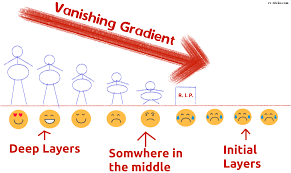


## ResNet




Первая ОЧЕНЬ глубокая нейросеть. Достигнуто это за счет двух вещей:

1) добавили в нейросеть BatchNorm, иначе она просто не училась. Его мы разберем на следующей лекции


### Не всегда более сложная зависимость дает лучшее решение


<img src="https://d2l.ai/_images/functionclasses.svg" >

Пример - $$f(x) = w_3x^3 + w_2x^2$$ более сложная функция, чем

$$f(x) = w_1x + w_0$$

Но первую функцию нельзя свести ко второй - будут существовать случаи, когда вторая функция будет работать в качестве аппроксимации, а первая - нет

Пример - $$f(x) = w_3x^3 + w_2x^2 + w_1x + w_0$$ более сложная функция, чем

$$f(x) = w_1x + w_0$$

И если нам не нужны  степени x выше первой для решения задачи, то мы просто говорим, что

$$w_3 = w_2 = 0$$

При усложнение нейросети, у нее должна оставаться **возможность проигнорировать добавленную сложность и свести себя к более простому решению**.

Например, хорошо, если нейросеть может делать так, что дополнительные слои дают **нулевой вклад** в предсказание

### Residual connections



Для этого в нейросеть можно добавить residual connections


<img src="https://d2l.ai/_images/residual-block.svg" width="500px">

А именно - выход предыдущего блока суммируется с выходом текущего. За счет этого нейросеть может решить, что какой-то блок ей в принципе не нужен и он просто будет выдавать тождественный 0.

Фактически - мы даем нейросети заранее много блоков подряд, соединенных таким образом. А она сама решает - использовать ей их все или часть выкинуть.



Конкретно в случае с ResNet residual блоки выглядят так.

<img src="https://d2l.ai/_images/resnet-block.svg" width="500px">

Второй вариант используется в глубоких вариациях ResNet

<img src="https://kodomo.fbb.msu.ru/FBB/year_21/grad_resnet.png" width="300px">  


За счет этого получилось делать огромные нейросети


<img src ="https://miro.medium.com/max/1400/1*S3TlG0XpQZSIpoDIUCQ0RQ.jpeg " width="1200">


Часто в прикладных задачах используют нейросеть с 34 слоями.

Но на ImageNet выступал ResNet с 152 слоями (а можно делать еще больших монстров - была бы память. Хотя прирост качества с какого-то момента минимален)

ResNet с 34 слоями - частый начальный выбор для многих задач, связанных с изображениями. Учить его не очень сложно, поведение предсказуемо и он дает хорошее качество

### Поверхность функции ошибки

Оказывается, skip-connections сильно упрощают поверхность функции ошибки - в результате градиентному спуску намного легче найти решение

<img src="https://kodomo.fbb.msu.ru/FBB/year_21/loss_landscape.png" width="500px">  

## DenseNet




Вместо сложения можно конкатенировать вход и выход слоя. Так делают в [DenseNet](https://arxiv.org/abs/1608.06993)

<img src ="https://media.springernature.com/lw685/springer-static/image/art%3A10.1007%2Fs12559-020-09776-8/MediaObjects/12559_2020_9776_Fig5_HTML.png" width="600">

Основная идея - в пределах блока сети переиспользовать feature map. Что это значит - слой получает не только выход предыдущего слоя, но сконкатенированный выход всех предыдущих слоев.

Почему это может давать бонус?
Часто для построения нового признака нам нужны не только высокоуровневые признаки, но и более низкоуровневые. В итоге в стандартной архитектуре нейросеть будет использовать часть фильтров для "хранения" хороших низкоуровневых признаков с предыдущих слоев. А так она может сосредоточиться на вычислении новых признаков.



Оказывается, это еще больше улучшает сходимость.

<img src="https://imgs.developpaper.com/imgs/38Kd2t.png" width="500px">





Правда, работает такая нейросеть дольше и потому используют ее реже

### Архитектурные улучшения ResNet

Обзор небольшой здесь - https://www.youtube.com/watch?v=KWuHPCDx7Bk

#### Squeeze-and-Excitation block

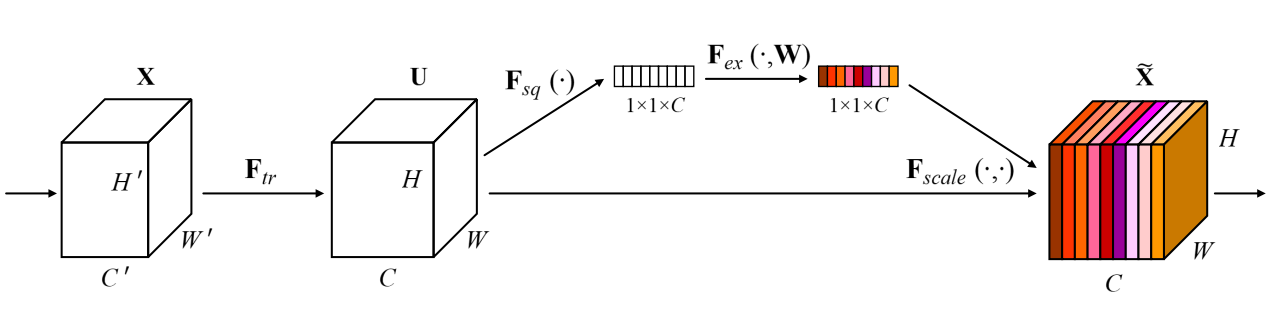

#### Inverted resnet block

Вместо того, чтобы на внутреннем слое сжимать представление, а потом расжимать - сделаем наоборот



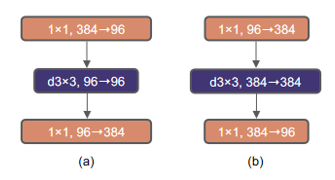

#### GeLU


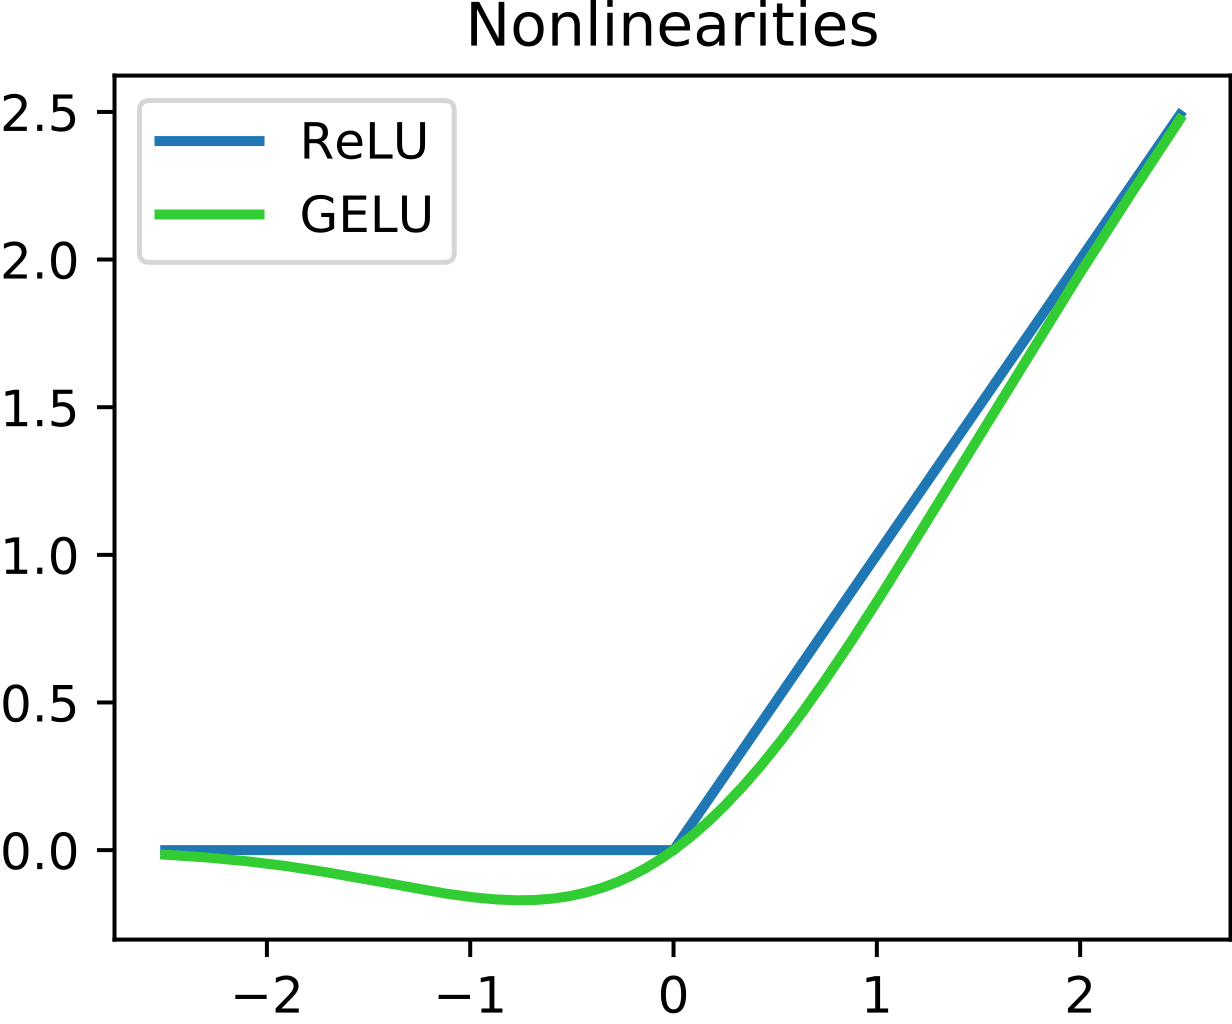

### Аугментация



<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1186%2Fs40537-019-0197-0/MediaObjects/40537_2019_197_Fig3_HTML.jpg?as=webp">



<img src="https://media.springernature.com/lw685/springer-static/image/art%3A10.1186%2Fs40537-019-0197-0/MediaObjects/40537_2019_197_Fig4_HTML.jpg?as=webp">

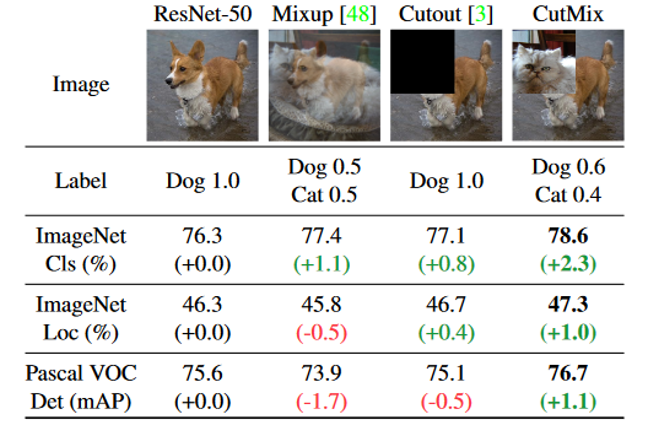

#### Label smoothing

Добавляем к нашим one-hot классам небольшой шум, вместо 1 target классу ставим меньшее значение $\epsilon$, а к остальным классам добавляем $\epsilon / (k-1)$

В частности, помогает бороться вот с этим:
https://labelerrors.com/

## Многообразие архитектур

Архитектур для классификации изображений великое множество. Часть из них считаются быстрее, часть из них дают результат точнее. В большинстве случаев вам хватит ResNet, потому рассматривать все эти архитектуры мы не будем

<img src ="https://kodomo.fbb.msu.ru/FBB/year_20/ml/many_arch.png" width="900">



И это еще не все.

Например, сейчас популярные архитектуры - это ConvNeXt, основанный на ResNet.

И EfficientNetV2 - сверточная сеть, архитектуры которой была получена при помощи NAS - neural architecture search.

По картинке видно, что эти архитектуры легко бьют архитектуры, основанные на трансформерах. Особенно характерна в этом плане EfficientNetV2, не отличающаяся сильно по числу операций от ResNet (сравните с трансформерами). Потому рассказы об универсальной архитектуре трансформеров (будут разобраны в одной из следующих лекций) несколько преувеличины

<img src="https://drive.google.com/uc?export=view&id=1EzgT93HBIDM_Oa9GtwbjhEY3cq3tfMXh" width=500px>

# Применение сверточных нейронных сетей в биологии

## Анализ медицинский изображений

Самое очевидное - их можно применять к тому же, в чем они и в общем успешны.




### Классификация клеток крови

![alttext](https://media.springernature.com/lw685/springer-static/image/art%3A10.1007%2Fs42979-021-00458-2/MediaObjects/42979_2021_458_Fig5_HTML.png?as=webp)

[ссылка на статью](https://link.springer.com/article/10.1007%2Fs42979-021-00458-2)


### Диагностика опухолей

![alttext](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8001442/bin/brainsci-11-00352-g002.jpg)

[ссылка на статью1](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8001442/)


### Сегментация изображений. U-Net

Активно применяются нейронные сети и для сегментации медицинских изображений.

Особо известная архитектура из использущихся - U-Net

![alttext](https://images.deepai.org/converted-papers/2004.10696/unet.png)

Основная идея - мы анализируем изображение сразу на разных масштабах, а потом объединям признаки с разных уровней. Это очень похоже на DenseNet по идее. Что непохоже - на выходе мы получаем не предсказание, а тоже изображение. Только не изначальное, а его сегментацию на интересующие нас регионы.

[ссылка на изначальную статью](https://arxiv.org/abs/1505.04597)


[ссылка на статью](https://www.nature.com/articles/s41598-021-87496-1)

## Работа с последовательностями ДНК

Внезапно, можно представлять последовательность ДНК в виде одномерного сигнала с 4 каналами (A, T, G, C).

Далее к такому сигналу можно применять 1d конволюции, получая сверточную нейронную сеть.



### Предсказание связывания транскрипционных фактров

Используя такие нейросети, мы можем точнее предсказывать связывание транскрипционных факторов и их комплексов с ДНК

![alttext](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41576-019-0122-6/MediaObjects/41576_2019_122_Fig2_HTML.png?as=webp)

Классический пример такой нейросети - [DeepBind](https://www.nature.com/articles/nbt.3300)

При этом в идеальном случае первый конволюционный слой выучит мотивы факторов. Но часто этого [не произойдет](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6941814/).  В менее идеальном - придется анализировать то, на что реагирует нейросеть в последовательностях и на основе анализа вытаскивать мотивы (разберем в одной из следующих лекций)





Аналогично, кроме самой последовательности, к сигналу могут добавляться дополнительные каналы, как это делается, например, в [FactorNet](https://www.nature.com/articles/s41576-019-0122-6)

![alttext](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6708499/bin/nihms-1525354-f0001.jpg)

Примером может служить deepSea. Данная нейросеть была обучена на данных ENCODE предсказывать по последовательности результаты 919 экспериментов по определению ДНКазной доступности, связывания транскрипционных факторов и других геномных признаков, померенных для разных клеточных линий в разных условиях

### Предсказание последствий однонуклеотидных мутаций в регуляторных регионах

Кроме того, можно выучить нейросеть предсказывать на основе последовательности результаты экспериментов - ChIPSeq, доступность хроматина и т.д

После этого можно предсказывать результаты экспериментов для последовательностей с заменами и на основе разницы с изначальной последовательностью, предсказывать эффекты этих замен.

Так делает DeepSEA

<img src ="https://kodomo.fbb.msu.ru/FBB/year_20/ml/deepsea.png" width="900">

Basenji

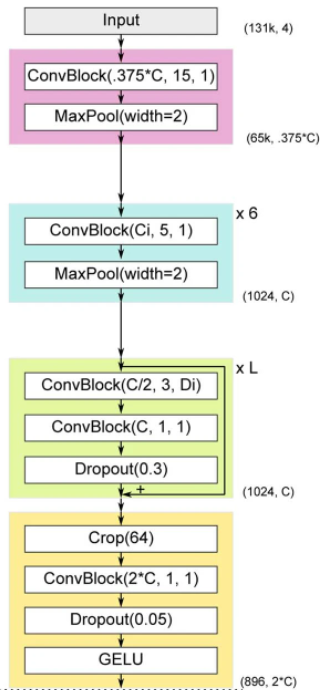

В случае Basenji2 используются данные и человека, и мыши

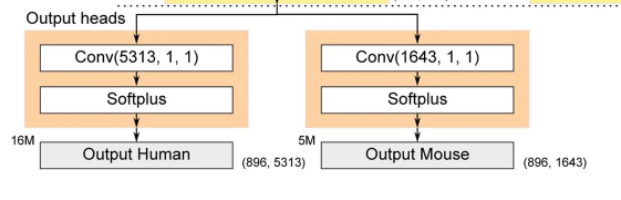

## Работа с последовательностью РНК


Точно также можно работать конволюциями и с последовательностью РНК.





### Предсказание рибопереключателей

Например, в [статье](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7541510/) CNN является частью архитектуры, с помощью которой авторы предсказывают является ли участок рибопереключателем и насколько хорош он в этой роли.

![alttext](https://theaisummer.com/static/1bb28dc710628228f7d7739ec992d307/21b4d/riboregulators.png)


### Предсказание остановки рибосомы

В данной [работе](
https://www.sciencedirect.com/science/article/pii/S240547121730337X) при помощи CNN пыытались предсказывать остановку рибосомы

![alttext](https://kodomo.fbb.msu.ru/FBB/year_20/ml/ribosome_stalling.png)


### Предсказание вторичной структуры РНК

В этой [работе](https://arxiv.org/pdf/2002.05810.pdf) CNN используется как части архитектуры бОльшей сети


![alttext](https://kodomo.fbb.msu.ru/FBB/year_20/ml/E2Efold.png)


### Предсказание сайтов сплайсинга


В [работе](https://www.cell.com/cell/fulltext/S0092-8674(18)31629-5) CNN используется для предсказания сайта связывания.
Используемая CNN представлеят собой немного видоизмененый ResNet  - добавлены дополнительные skip connections от некоторых промежуточных слоев к предпоследнеему. Кроме того, в части слоев вместо обычных конволюций используются dilated.



<img src ="https://kodomo.fbb.msu.ru/FBB/year_20/ml/SpliceAI.png" width="500">


<img src ="https://kodomo.fbb.msu.ru/FBB/year_20/ml/SpliceAI2.jpeg" width="500">

## Применение 3D конволюций в биологии

Отдельно стоит отметить применение конволюций, которые работают с трехмерными объектами. Трехмерные конволюции в принципе применяются реже, так как обучать такие нейросети сложнее, количество параметровв в них растет быстрее и для многих биологических задач, кроме того, свойственно то, что 3D изображение очень разряженно - в нем содержится ненулевой сигнал только в малой части районов


### DeepDrug3D

Например, в данной [работе](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006718) используется трехмерное представление структуры белка и последующие 3D конволюции для классификации сайтов связывания

![alttext](https://kodomo.fbb.msu.ru/FBB/year_20/ml/DeepDrug3D.png)

### Сегментацию изображений эмбрионов
В данной [работе](https://www.nature.com/articles/s41540-020-00152-8) используется 3D для сегментации 3D изображений эмбрионов на индивидуальные клетки

![alttext](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41540-020-00152-8/MediaObjects/41540_2020_152_Fig3_HTML.png?as=webp)

# * Upsampling

В рассмотренных архитектурах CNN для сегментации есть момент, когда мы из изображение меньшей размерности получаем изображение большей размерности.

Обычная конволюция так сделать не может. Тем более, размеры повышаются кратно.

Процедура эта называется upsampling и для нее есть несколько способов.



## Transposed convolution

Первый состоит в применении слоя Transposed convolution. Этот слой работает образом, похожим на обычную свертку:



![alttext](https://miro.medium.com/max/688/1*KGrCz7aav02KoGuO6znO0w.gif)

Отличие лишь в том, что мы сделали очень сильный паддинг входного изображения

С ним есть беда - он приводит к так называемому checkboard паттерну (подробнее - [здесь](https://distill.pub/2016/deconv-checkerboard/))

## Interpolation + Convolution

Вместо этого сначала делают [билинейную интерполяцию](https://theailearner.com/2018/12/29/image-processing-bilinear-interpolation/), которая повышает размерность изображения

![alttext](https://i1.wp.com/theailearner.com/wp-content/uploads/2018/10/Bilinear_interpolation.png?w=423&ssl=1)


а затем применяют обычную конволюцию с padding="same", которая убирает артефакты, вносимые билейнейно интерполяцией